In [6]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import dateutil

# Generators and Iterators

In [1]:
# That's a list >>
A = [i for i in range(5)]

In [2]:
A

[0, 1, 2, 3, 4]

In [3]:
# That's a generator >>
A = (i for i in range(5))

In [4]:
A

<generator object <genexpr> at 0x10f5d9a98>

In [15]:
next(A)

0

The objectives of the lab:

<ol type="1">
<li>Using the “tips” data set that comes with the seaborn package, we would like to find the median size of dining parties using the histogram method. We'd also be looking at how to a generator that produces a scatter plot in a streaming fashion with each chunk has a different color</li>

<li>Plotting the number of trips taken by hour of the day in the citbike data set (distributed in NYU Classes). In this task, we would write a generator to convert each line of an input citibike CSV into a stream of “hour of the day” values</li>
</ol>

In [7]:
sns.set_style("whitegrid")
sns.set_color_codes("muted")

tips = sns.load_dataset("tips")

## NOTE: the "tips" dataset comes with the seaborn package. But
## if it's not available to you for any reason, you can get it
## online by uncomenning the line below
#  tips = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/tips.csv')

In [8]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [16]:
## We are creating a GENERATOR from a list by calling __iter__().
## We can only iterate through all elements once for each generator.
sizes = list(tips['size']).__iter__()

In [17]:
type(sizes)

list_iterator

In [18]:
## Constructing the bins for finding the median
count = {}
for i in sizes:
    count[i] = count.get(i, 0)+1 # .get makes it work
print(count)
print(type(count))

{2: 156, 3: 38, 4: 37, 1: 4, 6: 4, 5: 5}
<class 'dict'>


In [21]:
## Create a DataFrame from our bins. This is just a way
## of doing it.

#data = {'size': count.keys(), 'count': count.values()}
#df = pd.DataFrame.from_dict(data)

data = {'size': list(count.keys()), 'count': list(count.values())}
df = pd.DataFrame.from_dict(data)

In [22]:
df

,count,size
0,156,2
1,38,3
2,37,4
3,4,1
4,4,6
5,5,5


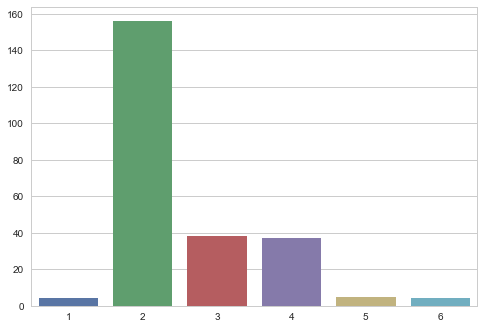

In [23]:
## By plotting the bins (aka histogram), we can see that
## the median party size of the restaurant was 2.

ax = sns.barplot(x="size", y="count", data=data, ci=None)

In [25]:
## But how can we determine it computationally?
## The algorithm is straight forward, we just pick the first
## bin where the cummulative count exceeds the 50 percentile.
current = 0
total = sum(count.values())
for k,v in sorted(count.items()):
    current += v
    if current*2>=total:
        print(k)
        break

2


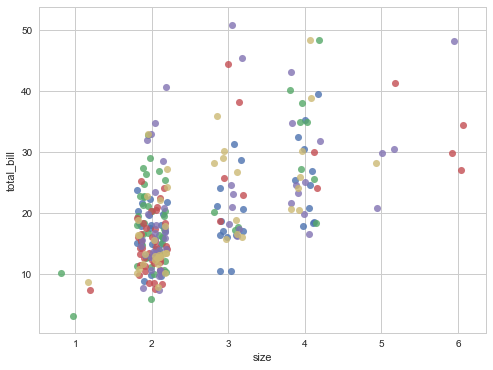

In [31]:
## Instead of processing elements one by one, we could
## process data "chunk by chunk" to increase the data
## rate. Below is an example of how we divide the data
## in to chunks and mark each chunk with different colors.

plt.figure(figsize=(8, 6))

bill_size = tips[['total_bill', 'size']]

def data_stream(bs, chunk_size=50):
    for i in range(0, len(bs), chunk_size):
        yield bs[i:i+chunk_size] # "yeild" is the generator

for chunk in data_stream(tips): #jitter makes us see something 
    sns.regplot(x="size", y="total_bill", data=chunk, x_jitter=.2, fit_reg=False, scatter_kws={"s": 50})

<br /><br /><br /><br />
Next we're looking at how to stream processing data from a CSV file. Again, we would like to plot the number of trips taken by hour of the day in the citbike data set (distributed in NYU Classes).

In [29]:
## This is how we usually read data from a CSV file.
## In this example, we extract the day of the week and
## the hour of the day from the "starttime" field. We
## print out these information for the line of the file.

with open('citibike.csv', 'r') as fi:
    reader = csv.DictReader(fi)
    for row in reader:
        starttime = dateutil.parser.parse(row['starttime'])
        print(row['starttime'])
        print(starttime.weekday(), starttime.hour)
        break

2015-02-01 00:00:00+00
6 0


In [32]:
## If we want to create a generator to iterate through
## through all the "hour of the day" in the files, we
## can create a wrapper function around our approach
## above. Note the use of "yield".

def citibike2hod(filename):
    with open(filename, 'r') as fi:
        reader = csv.DictReader(fi)
        for row in reader:
            starttime = dateutil.parser.parse(row['starttime'])
            yield starttime.hour

In [33]:
## We can then use a similar method to task 1 to compute
## and plot the histogram of the bike ride per hour.

count = {}
for hod in citibike2hod('citibike.csv'):
    count[hod] = count.get(hod, 0)+1

In [34]:
count

{0: 401,
 1: 248,
 2: 117,
 3: 89,
 4: 89,
 5: 293,
 6: 988,
 7: 2037,
 8: 3668,
 9: 3108,
 10: 2241,
 11: 2090,
 12: 2289,
 13: 2443,
 14: 2685,
 15: 2856,
 16: 3471,
 17: 4788,
 18: 4270,
 19: 2839,
 20: 1844,
 21: 1343,
 22: 1192,
 23: 811}

In [37]:
data = {'hod': list(count.keys()), 'count': list(count.values())}
df = pd.DataFrame.from_dict(data)

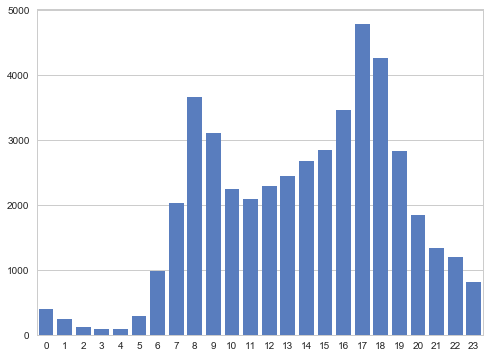

In [38]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(x="hod", y="count", data=data, color="b", ci=None)